In [1]:
import tensorflow as tf
tf.test.gpu_device_name()
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2023-09-04 02:04:13.456111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 02:04:14.574393: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-09-04 02:04:14.574512: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or di

'/device:GPU:0'

2023-09-04 02:04:17.558098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-04 02:04:17.634542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-04 02:04:17.636573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-04 02:04:19.335628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-04 02:04:19.340892: I tensorflow/compiler/xla/stream_executo

In [3]:
####--------------------------------------------- Part1: Read UCI Data (1000 Patients per file)----------------------------------------------------####

## 1. Open a 1000 patients mat file of UCI dataset
import scipy.io
data = scipy.io.loadmat('/home/yanweijin/BP_Model/Data/Cuffless_BP_Estimation/part_1.mat')
#### 'data' is a dictionary, { 'p': array([[array([[ 1.75953079e+00,  1.71847507e+00,  1.68426197e+00, ...}
#### data['p'].shape: (1, 1000). Which contains 1000 patients.
#### Single patients data['p'][0, patient].shape is (3, 61000), patient1 for example, contains PPG, BP, ECG in order.

In [93]:
## 2. Choose a patient from UCI dataset
import numpy as np
import matplotlib.pyplot as plt

fs = 125
patient = 0
#n_seconds_to_load = 100 # seconds
n_seconds_to_load = int(data["p"][0,patient].shape[1] / fs)
signal_length = int(n_seconds_to_load * fs)
#print(signal_length)
patient_data = data['p'][0,patient][:,:signal_length]
print(f'Patient {patient} length: {data["p"][0,patient].shape[1]}, time: {n_seconds_to_load}')

## 3. Choose signals of this patient
pt_ori = {'PPG': patient_data[0], 'BP': patient_data[1], 'ECG': patient_data[2]}
#### type(signal_ori) is numpy.ndarray, signal_ori.shape = (1, 3000)

## 4. Show 3 signals
def show_3_signals(signal):
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 6), dpi=96)
    axs[0].plot(list(signal.values())[0])
    axs[0].set_title(list(signal.keys())[0])

    axs[1].plot(list(signal.values())[1])
    axs[1].set_title(list(signal.keys())[1])

    axs[2].plot(list(signal.values())[2])
    axs[2].set_title(list(signal.keys())[2])

    xtick_positions = np.arange(0, len(list(pt_ori.values())[0]), fs)
    xtick_labels = [f'{int(xtick_position/fs)}' for xtick_position in xtick_positions]
    plt.xticks(xtick_positions, xtick_labels)
    plt.xlabel('Time (seconds)', fontsize=12)
    fig.suptitle(f'Patient {patient}')
    plt.tight_layout()
    plt.savefig(f'Patient{patient}_{n_seconds_to_load}Sec_3signals.png', format='png')
    plt.show()
    return 

#show_3_signals(pt_ori)

Patient 0 length: 61000, time: 488


In [5]:
####------------------------------------------------------- Part1: Normalize PPG-BP-ECG signals ---------------------------------------------------------####

## 1. Normalize signals to [0,1]
pt_norm = {}
pt_norm['PPG'] = (pt_ori['PPG']-min(pt_ori['PPG'])) / (max(pt_ori['PPG'])-min(pt_ori['PPG']))
#pt_norm['BP'] = (pt_ori['BP']-min(pt_ori['BP'])) / (max(pt_ori['BP'])-min(pt_ori['BP']))
pt_norm['BP'] = pt_ori['BP']
pt_norm['ECG'] = (pt_ori['ECG']-min(pt_ori['ECG'])) / (max(pt_ori['ECG'])-min(pt_ori['ECG']))

#### type(signal_norm) is numpy.ndarray, signal_norm.shape = (1, 3000)

## 2. Show 3 signals
#show_3_signals(pt_norm)


In [6]:
import pandas as pd
import math

def find_points_in_all_beats_index(signal, height_cf=0.8, p_lth=2, p_ht=0.17):
    points_in_all_beats_index = pd.DataFrame(columns=(['P start index', 'P peak index', 'Q peak index', 'R peak index', 'S peak index', 'S end index', 'T peak index', 'T end index', 'ECG Min index', 'DBP index', 'SBP index', 'PPG valley index', 'PPG Max Slope index', 'PPG peak index']))
    ## 1. Find ECG Points
    ecg_r_height = min(signal['ECG']) + ((max(signal['ECG']) - min(signal['ECG'])) * height_cf)
    print(f'ECG R peak height > {ecg_r_height}')

    r_peak_index = []
    for i in range(1, (len(signal['ECG'])-1)):
        if (signal['ECG'][i] > signal['ECG'][i-1]) and (signal['ECG'][i] >= signal['ECG'][i+1]) and (signal['ECG'][i] >= ecg_r_height):
            r_peak_index.append(i)
    points_in_all_beats_index['R peak index'] = r_peak_index
    print(f'{len(r_peak_index)} r peak index: {r_peak_index}')

    ecg_min_index = []
    for index0, index1 in zip(r_peak_index[:-1], r_peak_index[1:]):
        ecg_min_index.append(index0 + np.argmin(signal['ECG'][index0:index1]))
    ecg_min_index.append(r_peak_index[-1] + np.argmin(signal['ECG'][r_peak_index[-1]:]))
    points_in_all_beats_index['ECG Min index'] = ecg_min_index
    print(f'{len(ecg_min_index)} ecg min index: {ecg_min_index}')   

    s_peak_index = []
    for index0, index1 in zip(r_peak_index, ecg_min_index):
        ecg_second_half = signal['ECG'][index0:index1]
        s_peak_in_one_beat_index = []
        s_peak_in_one_beat = []
        for i in range(index0+1, index1-1):
            if (signal['ECG'][i] < signal['ECG'][i-1]) and (signal['ECG'][i] < signal['ECG'][i+1]):
                s_peak_in_one_beat_index.append(i)
                s_peak_in_one_beat.append(signal['ECG'][i])
        if len(s_peak_in_one_beat_index) > 0:
            s_peak_index.append(s_peak_in_one_beat_index[s_peak_in_one_beat.index(min(s_peak_in_one_beat))])
        else:
            s_peak_index.append(index1)
    points_in_all_beats_index['S peak index'] = s_peak_index
    print(f'{len(s_peak_index)} s peak index: {s_peak_index}')   

    p_peak_index = []
    p_peak_in_one_beat_index = []
    for i in range(1, r_peak_index[0]):
        if (signal['ECG'][i] > signal['ECG'][i-1]) and (signal['ECG'][i] > signal['ECG'][i+1]):
            p_peak_in_one_beat_index.append(i)
    if len(p_peak_in_one_beat_index) > 0:
        p_length = (s_peak_index[0] - r_peak_index[0]) * p_lth
        p_height = (signal['ECG'][r_peak_index[0]] - signal['ECG'][s_peak_index[0]]) * p_ht
        p_peak_right_index = []
        for p in p_peak_in_one_beat_index:
            if ((r_peak_index[0] - p) >= p_length) and ((signal['ECG'][p] - signal['ECG'][s_peak_index[0]]) >= p_height):
                p_peak_right_index.append(p)
        if len(p_peak_right_index) > 0:
            p_peak_index.append(p_peak_right_index[-1])
        else:
            p_peak_index.append(np.nan)
    else:
        p_peak_index.append(np.nan)

    for i in range(len(s_peak_index) - 1):
        #print(i)
        index_one = s_peak_index[i]
        index_two = r_peak_index[i + 1]
        p_peak_in_one_beat_index = []
        for j in range(index_one, index_two):
            if (signal['ECG'][j] >= signal['ECG'][j - 1]) and (signal['ECG'][j] > signal['ECG'][j + 1]):
                p_peak_in_one_beat_index.append(j)
        if len(p_peak_in_one_beat_index) > 0:
            #print(f'len(p_peak_in_one_beat_index) > 0: {p_peak_in_one_beat_index}')
            p_length = (s_peak_index[i+1] - r_peak_index[i+1]) * p_lth
            #print(f'p_length {p_length}')
            p_height = (signal['ECG'][r_peak_index[i+1]] - signal['ECG'][s_peak_index[i+1]]) * p_ht
            #print(f'p_height{p_height}')
            p_peak_right_index = []
            for p in p_peak_in_one_beat_index:
                #print(f'have a p:{p}')
                #print((r_peak_index[i+1] - p))
                if ((r_peak_index[i+1] - p) >= p_length) and ((signal['ECG'][p] - signal['ECG'][s_peak_index[i+1]]) >= p_height):
                    #print(f'have a p:{p}')
                    p_peak_right_index.append(p)
            if len(p_peak_right_index) > 0:
                #print('len(p_peak_right_index) > 0')
                p_peak_index.append(p_peak_right_index[-1])
            else:
                p_peak_index.append(np.nan)
        else:
            p_peak_index.append(np.nan)
    points_in_all_beats_index['P peak index'] = p_peak_index
    print(f'{len(p_peak_index)} p peak index: {p_peak_index}')   

    q_peak_index = []
    for i in range(len(p_peak_index)):
        if math.isnan(p_peak_index[i]):
            q_peak_index.append(np.nan)
        else:
            q_peak_index.append(p_peak_index[i] + np.argmin(signal['ECG'][p_peak_index[i]:r_peak_index[i]]))
    points_in_all_beats_index['Q peak index'] = q_peak_index
    print(f'{len(q_peak_index)} q peak index: {q_peak_index}')

    p_start_index = []
    p_start_in_one_beat_index = []
    if np.isnan(p_peak_index[0]):
        p_start_index.append(np.nan)
    else:
        for i in range(1, p_peak_index[0]):
            if signal['ECG'][i-1] == signal['ECG'][i] == signal['ECG'][i+1]:
                p_start_in_one_beat_index.append(i+1)
        if len(p_start_in_one_beat_index) > 0:
            p_start_index.append(p_start_in_one_beat_index[-1])
        else:
            p_start_index.append(p_peak_index[0] - (q_peak_index[0] - p_peak_index[0]))

    for i in range(len(s_peak_index) -1):
        if math.isnan(p_peak_index[i+1]):
            p_start_index.append(np.nan)
        else:
            p_start_in_one_beat_index = []
            for j in range((s_peak_index[i]+1),(p_peak_index[i+1]-1)):
                if signal['ECG'][j-1] == signal['ECG'][j] == signal['ECG'][j+1]:
                    p_start_in_one_beat_index.append(j+1)
            if len(p_start_in_one_beat_index) > 0:
                p_start_index.append(p_start_in_one_beat_index[-1])
            else:
                p_start_index.append(p_peak_index[i+1] - (q_peak_index[i+1] - p_peak_index[i+1]))
    points_in_all_beats_index['P start index'] = p_start_index
    print(f'{len(p_start_index)} p start index: {p_start_index}')

    t_peak_index = []
    for i in range(len(s_peak_index)-1):
        t_peak_in_one_beat = 0
        if math.isnan(p_start_index[i+1]):
            index0 = s_peak_index[i]
            index1 = r_peak_index[i+1]
        else:
            index0 = s_peak_index[i]
            index1 = p_start_index[i+1]

        for j in range((index0+1), (index1-1)):
            if (signal['ECG'][j] > signal['ECG'][j-1]) and (signal['ECG'][j] > signal['ECG'][j+1]):
                t_peak_index.append(j)
                t_peak_in_one_beat += 1
                #print(j)
                break
        if t_peak_in_one_beat == 0:
            t_peak_index.append(np.nan)
            #print('nan')

    t_peak_in_one_beat = 0
    for i in range((s_peak_index[-1]+1),(len(signal['ECG'])-1)):
        if signal['ECG'][i] > signal['ECG'][i-1] and signal['ECG'][i] > signal['ECG'][i+1]:
            t_peak_index.append(i)
            t_peak_in_one_beat += 1
            break
    if t_peak_in_one_beat == 0:
        t_peak_index.append(np.nan)
    points_in_all_beats_index['T peak index'] = t_peak_index
    print(f'{len(t_peak_index)} t peak index: {t_peak_index}')

    ## 2. Find BP Points
    sbp_index = []
    dbp_index = []
    for i in range(len(r_peak_index) - 1):
        index0 = r_peak_index[i]
        index1 = r_peak_index[i+1]
        sbp_index.append(index0 + np.argmax(signal['BP'][index0:index1]))
        if sbp_index[-1] > index0:
            dbp_index.append(index0 + np.argmin(signal['BP'][index0:sbp_index[-1]]))
        else:
            dbp_index.append(np.nan)
    for i in range(r_peak_index[-1]+1,len(signal['BP'])-1):
        if (signal['BP'][i] <= signal['BP'][i-1]) and (signal['BP'][i] < signal['BP'][i+1]):
            dbp_index.append(i)
            break
    if dbp_index[-1] > sbp_index[-1]:
            for i in range(dbp_index[-1]+1, len(signal['BP'])-1):
                if (signal['BP'][i] > signal['BP'][i-1]) and (signal['BP'][i] >= signal['BP'][i+1]):
                    sbp_index.append(i)
                    break
            if len(sbp_index) == len(dbp_index):
                pass
            else:
                sbp_index.append(np.nan)
    else:
        sbp_index.append(np.nan)
        dbp_index.append(np.nan)

    points_in_all_beats_index['SBP index'] = sbp_index
    points_in_all_beats_index['DBP index'] = dbp_index
    print(f'{len(sbp_index)} sbp index: {sbp_index}, \n{len(dbp_index)} dbp index: {dbp_index}')

    ## 3. Find PPG Points
    ppg_peak_index = []
    ppg_valley_index = []
    ppg_max_slope_index = []

    def get_ppg_points(site=(len(sbp_index)-1)): #site=(len(sbp_index)-1)
        for i in range(site):
            if not np.isnan(dbp_index[i]):
                index0 = sbp_index[i]
                index1 = sbp_index[i+1]
                ppg_peak_index.append(index0 + np.argmax(signal['PPG'][index0:index1]))
                #print(ppg_peak_index)
                index0 = dbp_index[i]
                index1 = ppg_peak_index[-1]
            #if index1 > index0:
                ppg_valley_index.append(index0 + np.argmin(signal['PPG'][index0:index1]))
            #else:
                #ppg_valley_index.append(index0)
                max_slope = 0
                slope_index = ppg_valley_index[-1]
                for j in range(ppg_valley_index[-1],ppg_peak_index[-1]):
                    one_slope = signal['PPG'][j+1] - signal['PPG'][j]
                    if one_slope > max_slope:
                        max_slope = one_slope
                        slope_index = j
                ppg_max_slope_index.append(slope_index)
            else:
                ppg_peak_index.append(np.nan)
                ppg_max_slope_index.append(np.nan)
                ppg_valley_index.append(np.nan)
                
        for i in range(sbp_index[site]+1,len(signal['PPG'])-1):
            if (signal['PPG'][i] < signal['PPG'][i-1]) and (signal['PPG'][i] < signal['PPG'][i+1]):
                ppg_valley_index.append(i)
                break
        #print(f'ppg_valley_index[-1]:{ppg_valley_index[-1]}, ppg_peak_index[-1]:{ppg_peak_index[-1]}')
        if len(ppg_valley_index) > len(ppg_peak_index):
            #print('yes')
            for j in range(ppg_valley_index[-1]+1, len(signal['PPG'])-1):
                if (signal['PPG'][j] > signal['PPG'][j-1]) and (signal['PPG'][j] > signal['PPG'][j+1]):
                    ppg_peak_index.append(j)
                    break
            if ppg_peak_index[-1] > ppg_valley_index[-1]:
                max_slope = 0
                slope_index = ppg_valley_index[-1]
                for k in range(ppg_valley_index[-1], ppg_peak_index[-1]-1):
                    one_slope = signal['PPG'][k+1] - signal['PPG'][k]
                    if one_slope > max_slope:
                        max_slope = one_slope
                        slope_index = k
                ppg_max_slope_index.append(slope_index)
            else:
                ppg_peak_index.append(np.nan)
                ppg_max_slope_index.append(np.nan)
        else:
            ppg_peak_index.append(np.nan)
            ppg_max_slope_index.append(np.nan)
            ppg_valley_index.append(np.nan)
        
        return

    if not np.isnan(sbp_index[-1]):
        site = len(sbp_index) - 1
        get_ppg_points(site)

    else:
        site = len(sbp_index) - 2
        get_ppg_points(site)
        ppg_peak_index.append(np.nan)
        ppg_max_slope_index.append(np.nan)
        ppg_valley_index.append(np.nan)

    print(f'{len(ppg_peak_index)} ppg peak index: {ppg_peak_index}, \n{len(ppg_valley_index)} ppg valley index: {ppg_valley_index}, \n{len(ppg_max_slope_index)} ppg max slope index: {ppg_max_slope_index}')
    points_in_all_beats_index['PPG peak index'] = ppg_peak_index
    points_in_all_beats_index['PPG valley index'] = ppg_valley_index
    points_in_all_beats_index['PPG Max Slope index'] = ppg_max_slope_index
    points_in_all_beats_index.to_csv(f'Patient{patient}_{n_seconds_to_load}Sec_{len(points_in_all_beats_index)}allpoints.csv', index=False)
    display(points_in_all_beats_index)

    return points_in_all_beats_index

def show_points_in_signals(points, signal):
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15,6), dpi=96)
    axs[0].plot(signal['PPG'])
    p_p_i = [int(i) for i in points['PPG peak index'] if not np.isnan(i)]
    axs[0].scatter(p_p_i, signal['PPG'][p_p_i])
    p_v_i = [int(i) for i in points['PPG valley index'] if not np.isnan(i)]
    axs[0].scatter(p_v_i, signal['PPG'][p_v_i])
    p_m_s_i = [int(i) for i in points['PPG Max Slope index'] if not np.isnan(i)]
    axs[0].scatter(p_m_s_i, signal['PPG'][p_m_s_i])
    axs[0].set_title(f'{list(signal.keys())[0]}: PPG peak, PPG valley, PPG Max Slope')

    axs[1].plot(signal['BP'])
    s_i = [int(i) for i in points['SBP index'] if not np.isnan(i)]
    axs[1].scatter(s_i, signal['BP'][s_i])
    d_i = [int(i) for i in points['DBP index'] if not np.isnan(i)]
    axs[1].scatter(d_i, signal['BP'][d_i])
    axs[1].set_title(f'{list(signal.keys())[1]}: SBP, DBP')

    axs[2].plot(signal['ECG'])
    p_s_i = [int(i) for i in points['P start index'] if not np.isnan(i)]
    axs[2].scatter(p_s_i, signal['ECG'][p_s_i], label='Start')
    p_pk_i = [int(i) for i in points['P peak index'] if not np.isnan(i)]
    axs[2].scatter(p_pk_i, signal['ECG'][p_pk_i], label='P peak')
    q_pk_i = [int(i) for i in points['Q peak index'] if not np.isnan(i)]
    axs[2].scatter(q_pk_i, signal['ECG'][q_pk_i], label='Q peak')
    r_pk_i = [int(i) for i in points['R peak index'] if not np.isnan(i)]
    axs[2].scatter(r_pk_i, signal['ECG'][r_pk_i], label='R peak')
    s_pk_i = [int(i) for i in points['S peak index'] if not np.isnan(i)]
    axs[2].scatter(s_pk_i, signal['ECG'][s_pk_i], label='S peak')
    t_pk_i = [int(i) for i in points['T peak index'] if not np.isnan(i)]
    axs[2].scatter(t_pk_i, signal['ECG'][t_pk_i], label='T peak')
    #e_m_i = [int(i) for i in points['ECG Min index'] if not np.isnan(i)]
    #axs[2].scatter(e_m_i, signal['ECG'][e_m_i], label='Ecg min')
    axs[2].set_title(f'{list(signal.keys())[2]}: Start, P-peak, QRS-peak, T-peak, ECG Min')
    axs[2].legend()

    xtick_positions = np.arange(0, len(signal['ECG']), fs)
    xtick_labels = [f'{int(xtick_position/fs)}' for xtick_position in xtick_positions]
    plt.xticks(xtick_positions, xtick_labels)
    plt.xlabel('Time (seconeds)', fontsize=12)
    fig.suptitle(f'Patient {patient} key points')
    plt.tight_layout()
    plt.savefig(f'Patient{patient}_{n_seconds_to_load}Sec_{len(p_s_i)}PotinSnls.png', format='png')
    return plt.show()

points_in_all_beats_index = find_points_in_all_beats_index(pt_ori)

#show_points_in_signals(points = points_in_all_beats_index, signal = pt_ori)

ECG R peak height > 1.1526881720430109
971 r peak index: [38, 101, 162, 223, 285, 347, 408, 468, 529, 589, 650, 710, 770, 830, 890, 951, 1011, 1071, 1131, 1192, 1253, 1314, 1374, 1435, 1496, 1557, 1617, 1677, 1739, 1800, 1861, 1921, 1983, 2044, 2105, 2166, 2226, 2287, 2348, 2409, 2469, 2529, 2590, 2650, 2711, 2770, 2830, 2890, 2951, 3011, 3071, 3131, 3191, 3252, 3313, 3374, 3434, 3496, 3557, 3619, 3679, 3740, 3802, 3863, 3924, 3985, 4046, 4107, 4168, 4228, 4289, 4350, 4411, 4473, 4533, 4594, 4656, 4717, 4779, 4841, 4903, 4966, 5041, 5100, 5160, 5221, 5281, 5341, 5401, 5463, 5524, 5586, 5647, 5709, 5771, 5833, 5895, 5956, 6018, 6080, 6141, 6203, 6264, 6325, 6387, 6448, 6510, 6571, 6633, 6695, 6757, 6819, 6880, 6942, 7003, 7065, 7125, 7187, 7248, 7310, 7371, 7432, 7494, 7556, 7618, 7680, 7742, 7805, 7867, 7929, 7991, 8054, 8116, 8178, 8240, 8301, 8363, 8425, 8487, 8548, 8609, 8671, 8732, 8794, 8855, 8916, 8978, 9040, 9101, 9163, 9225, 9287, 9350, 9411, 9474, 9536, 9599, 9698, 9760, 9822,

,P start index,P peak index,Q peak index,R peak index,S peak index,S end index,T peak index,T end index,ECG Min index,DBP index,SBP index,PPG valley index,PPG Max Slope index,PPG peak index
0,18.0,27.0,34.0,38,42,NaN,NaN,NaN,64,62,73.0,92.0,98.0,107.0
1,83.0,89.0,97.0,101,104,NaN,113.0,NaN,126,124,136.0,154.0,160.0,170.0
2,143.0,151.0,158.0,162,165,NaN,NaN,NaN,188,186,197.0,216.0,222.0,231.0
3,205.0,212.0,216.0,223,227,NaN,NaN,NaN,249,247,258.0,277.0,283.0,292.0
4,268.0,274.0,282.0,285,289,NaN,NaN,NaN,310,309,320.0,339.0,345.0,355.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,60707.0,60716.0,60724.0,60728,60731,NaN,NaN,NaN,60753,60751,60762.0,60780.0,60786.0,60795.0
967,60771.0,60778.0,60785.0,60789,60793,NaN,60804.0,NaN,60814,60812,60824.0,60841.0,60848.0,60857.0
968,60828.0,60839.0,60847.0,60850,60854,NaN,NaN,NaN,60875,60874,60885.0,60903.0,60909.0,60918.0
969,60865.0,60900.0,60906.0,60912,60915,NaN,NaN,NaN,60937,60935,60946.0,60964.0,60970.0,60979.0


In [27]:
## Save normal Points and get Features
fs = 125
def get_points_saved_index(points = points_in_all_beats_index):
    points_saved_index = pd.DataFrame(columns=(['P start index', 'P peak index', 'Q peak index', 'R peak index', 'S peak index', 'S end index', 'T peak index', 'T end index', 'ECG Min index', 'DBP index', 'SBP index', 'PPG valley index', 'PPG Max Slope index', 'PPG peak index']))
    #display(points_saved_index)
    for i in range(len(points)-1):
        #print(f'index:{i}')
        r_r = (points['R peak index'][i+1] - points['R peak index'][i]) / fs
        #print(f'r_r:{r_r}')
        if 1.2 >= r_r >= 0.4:
            if not np.isnan(points['P peak index'][i]):
                p_wave = ((points['P peak index'][i] - points['P start index'][i]) / fs) * 2
                p_r = (points['R peak index'][i] - points['P peak index'][i]) / fs
                #print(f'p_r:{p_r}')
                qrs_wave = (points['S peak index'][i] - points['Q peak index'][i]) / fs
                #print(f'qrs_wave:{qrs_wave}')
                if (p_wave > 0.1) and ((r_r/6) <= p_r <= (r_r/3)) and (qrs_wave <= 0.12):
                    if not np.isnan(points['DBP index'][i]):
                        points_saved_index = points_saved_index.append(points.iloc[i])
    points_saved_index.to_csv(f'Patient{patient}_{n_seconds_to_load}Sec_{len(points_saved_index)}Savedpoints.csv', index=False)
    display(points_saved_index)
    #if len(points_saved_index) > 0:
        #show_points_in_signals(points_saved_index, pt_norm)
    return points_saved_index
points_saved_index = get_points_saved_index()

,P start index,P peak index,Q peak index,R peak index,S peak index,S end index,T peak index,T end index,ECG Min index,DBP index,SBP index,PPG valley index,PPG Max Slope index,PPG peak index
0,18.0,27.0,34.0,38,42,NaN,NaN,NaN,64,62,73.0,92.0,98.0,107.0
2,143.0,151.0,158.0,162,165,NaN,NaN,NaN,188,186,197.0,216.0,222.0,231.0
3,205.0,212.0,216.0,223,227,NaN,NaN,NaN,249,247,258.0,277.0,283.0,292.0
5,326.0,335.0,343.0,347,350,NaN,NaN,NaN,372,370,382.0,400.0,407.0,416.0
6,388.0,396.0,404.0,408,411,NaN,NaN,NaN,433,431,443.0,462.0,468.0,477.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,60647.0,60655.0,60663.0,60667,60670,NaN,60680.0,NaN,60692,60690,60701.0,60719.0,60724.0,60734.0
966,60707.0,60716.0,60724.0,60728,60731,NaN,NaN,NaN,60753,60751,60762.0,60780.0,60786.0,60795.0
967,60771.0,60778.0,60785.0,60789,60793,NaN,60804.0,NaN,60814,60812,60824.0,60841.0,60848.0,60857.0
968,60828.0,60839.0,60847.0,60850,60854,NaN,NaN,NaN,60875,60874,60885.0,60903.0,60909.0,60918.0


In [23]:
def get_features_bps(points = points_saved_index, signal = pt_norm):
    points.reset_index(drop=True, inplace=True)
    features = pd.DataFrame()
    features['P wavelength'] = ((points['P peak index'] - points['P start index']) / fs) * 2
    features['P amplitude'] = [signal['ECG'][int(i)] for i in points['P peak index']]
    features['Q amplitude'] = [signal['ECG'][int(i)] for i in points['Q peak index']]
    features['R amplitude'] = [signal['ECG'][int(i)] for i in points['R peak index']]
    features['S amplitude'] = [signal['ECG'][int(i)] for i in points['S peak index']]
    features['QRS wavelength'] = (points['S peak index'] - points['Q peak index']) / fs
    features['P-R interval'] = (points['R peak index'] - points['P peak index']) / fs
    #features['R-R interval half'] = [((points['R peak index'][i+1] - points['R peak index'][i]) / (2 * fs)) for i in range(len(points)-1)]+[np.nan]
    features['PTT R-PPG peak'] = (points['PPG peak index'] - points['R peak index']) / fs
    features['PTT R-PPG Max Slope'] = (points['PPG Max Slope index'] - points['R peak index']) / fs
    features['PPG valley amplitude'] = [signal['PPG'][int(i)] for i in points['PPG valley index']]
    features['PPG peak amplitude'] = [signal['PPG'][int(i)] for i in points['PPG peak index']]
    features['PPG valley-slope interval'] = (points['PPG Max Slope index'] - points['PPG valley index']) / fs
    features['PPG valley-peak interval'] = (points['PPG peak index'] - points['PPG valley index']) / fs
    features['PPG slope'] = [((signal['PPG'][int(points['PPG peak index'][i])] - signal['PPG'][int(points['PPG valley index'][i])])/ (points['PPG peak index'][i] - points['PPG valley index'][i])) for i in range(len(points))]
    #features['PPG val-val interval half'] = [((points['PPG valley index'][i+1] - points['PPG valley index'][i]) / (2 * fs)) for i in range(len(points)-1)]+[np.nan]
    #features['PPG pk-pk interval half'] = [((points['PPG peak index'][i+1] - points['PPG peak index'][i]) / (2 * fs)) for i in range(len(points)-1)]+[np.nan]
    features['SBP'] = [signal['BP'][int(i)] for i in points['SBP index']]
    features['DBP'] = [signal['BP'][int(i)] for i in points['DBP index']]
    features['ABP'] = (features['SBP'] + features['DBP']) / 2
    features.to_csv(f'Patient{patient}_{n_seconds_to_load}Sec_{len(features)}features.csv', index=False)
    display(features)
    return features
features_bps = get_features_bps(points_saved_index, pt_norm)

#features = np.array((features_bps['P wavelength'], features_bps['P amplitude']))
#features = features.T
'''features = np.array(features_bps.iloc[:, :-3])
bps = np.array(features_bps.iloc[:, -3:])
#print(f'features shape: {features.shape}, \n{features} \nbps shape: {bps.shape}, \n{bps}')

## Reshape data to train LSTM model
time_step = 10
features_reshape = np.zeros(((features.shape[0] - time_step + 1), time_step, features.shape[1]))
for i in range(len(features_reshape)):
    features_reshape[i] = features[i : (time_step + i)]
bps_reshape = bps[time_step - 1: ]'''
#print(f'features_reshape: {features_reshape.shape}, \n{features_reshape}')
#print(f'bps_reshape: {bps_reshape.shape}, \n{bps_reshape}')

,P wavelength,P amplitude,Q amplitude,R amplitude,S amplitude,QRS wavelength,P-R interval,PTT R-PPG peak,PTT R-PPG Max Slope,PPG valley amplitude,PPG peak amplitude,PPG valley-slope interval,PPG valley-peak interval,PPG slope,SBP,DBP,ABP
0,0.144,0.402189,0.275891,0.968285,0.181027,0.064,0.088,0.552,0.48,0.283830,0.722277,0.048,0.120,0.029230,123.038299,67.307176,95.172737
1,0.128,0.324726,0.209655,0.815885,0.111984,0.056,0.088,0.552,0.48,0.266488,0.682218,0.048,0.120,0.027715,118.349265,65.597632,91.973448
2,0.112,0.364861,0.264384,0.910749,0.175133,0.088,0.088,0.552,0.48,0.293600,0.718613,0.048,0.120,0.028334,119.570367,66.134917,92.852642
3,0.144,0.399383,0.281504,0.959585,0.183834,0.056,0.096,0.552,0.48,0.285540,0.746947,0.056,0.128,0.028838,122.745234,67.502552,95.123893
4,0.128,0.387875,0.264384,0.936570,0.178221,0.056,0.096,0.552,0.48,0.278701,0.717147,0.048,0.120,0.029230,121.621820,67.600240,94.611030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,0.128,0.362054,0.232669,0.890542,0.132192,0.056,0.096,0.536,0.456,0.255252,0.723742,0.040,0.120,0.031233,130.609135,71.214704,100.911919
682,0.144,0.359248,0.244176,0.968285,0.160820,0.056,0.096,0.536,0.464,0.296043,0.731558,0.048,0.120,0.029034,132.123302,73.119624,102.621463
683,0.112,0.399383,0.272804,1.000000,0.175133,0.064,0.088,0.544,0.472,0.285784,0.736444,0.056,0.128,0.028166,134.663195,73.412689,104.037942
684,0.176,0.393489,0.258490,1.000000,0.163626,0.056,0.088,0.544,0.472,0.281387,0.725452,0.048,0.120,0.029604,134.418975,73.901130,104.160052


In [94]:
def get_pt_ftsbps(patient):
    n_seconds_to_load = int(data["p"][0,patient].shape[1] / fs)
    signal_length = int(n_seconds_to_load * fs)
    patient_data = data['p'][0,patient][:,:signal_length]
    print(f'Patient {patient} length: {data["p"][0,patient].shape[1]}, time: {n_seconds_to_load}')
    pt_ori = {'PPG': patient_data[0], 'BP': patient_data[1], 'ECG': patient_data[2]}
    
    pt_norm = {}
    pt_norm['PPG'] = (pt_ori['PPG']-min(pt_ori['PPG'])) / (max(pt_ori['PPG'])-min(pt_ori['PPG']))
    pt_norm['BP'] = (pt_ori['BP']-min(pt_ori['BP'])) / (max(pt_ori['BP'])-min(pt_ori['BP']))
    #pt_norm['BP'] = pt_ori['BP'] / 160
    pt_norm['ECG'] = (pt_ori['ECG']-min(pt_ori['ECG'])) / (max(pt_ori['ECG'])-min(pt_ori['ECG']))

    points_in_all_beats_index = find_points_in_all_beats_index(pt_ori)
    points_saved_index = get_points_saved_index(points_in_all_beats_index)
    features_bps = get_features_bps(points_saved_index, pt_norm)
    return features_bps

'''all_features_bps = pd.DataFrame()
for pt in range(5):
    patient = pt
    all_features_bps = pd.concat([all_features_bps, get_pt_ftsbps(pt)], ignore_index=True)'''
all_features_bps = get_pt_ftsbps(0)
display(all_features_bps)

Patient 0 length: 61000, time: 488
ECG R peak height > 1.1526881720430109
971 r peak index: [38, 101, 162, 223, 285, 347, 408, 468, 529, 589, 650, 710, 770, 830, 890, 951, 1011, 1071, 1131, 1192, 1253, 1314, 1374, 1435, 1496, 1557, 1617, 1677, 1739, 1800, 1861, 1921, 1983, 2044, 2105, 2166, 2226, 2287, 2348, 2409, 2469, 2529, 2590, 2650, 2711, 2770, 2830, 2890, 2951, 3011, 3071, 3131, 3191, 3252, 3313, 3374, 3434, 3496, 3557, 3619, 3679, 3740, 3802, 3863, 3924, 3985, 4046, 4107, 4168, 4228, 4289, 4350, 4411, 4473, 4533, 4594, 4656, 4717, 4779, 4841, 4903, 4966, 5041, 5100, 5160, 5221, 5281, 5341, 5401, 5463, 5524, 5586, 5647, 5709, 5771, 5833, 5895, 5956, 6018, 6080, 6141, 6203, 6264, 6325, 6387, 6448, 6510, 6571, 6633, 6695, 6757, 6819, 6880, 6942, 7003, 7065, 7125, 7187, 7248, 7310, 7371, 7432, 7494, 7556, 7618, 7680, 7742, 7805, 7867, 7929, 7991, 8054, 8116, 8178, 8240, 8301, 8363, 8425, 8487, 8548, 8609, 8671, 8732, 8794, 8855, 8916, 8978, 9040, 9101, 9163, 9225, 9287, 9350, 9411, 

,P start index,P peak index,Q peak index,R peak index,S peak index,S end index,T peak index,T end index,ECG Min index,DBP index,SBP index,PPG valley index,PPG Max Slope index,PPG peak index
0,18.0,27.0,34.0,38,42,NaN,NaN,NaN,64,62,73.0,92.0,98.0,107.0
1,83.0,89.0,97.0,101,104,NaN,113.0,NaN,126,124,136.0,154.0,160.0,170.0
2,143.0,151.0,158.0,162,165,NaN,NaN,NaN,188,186,197.0,216.0,222.0,231.0
3,205.0,212.0,216.0,223,227,NaN,NaN,NaN,249,247,258.0,277.0,283.0,292.0
4,268.0,274.0,282.0,285,289,NaN,NaN,NaN,310,309,320.0,339.0,345.0,355.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,60707.0,60716.0,60724.0,60728,60731,NaN,NaN,NaN,60753,60751,60762.0,60780.0,60786.0,60795.0
967,60771.0,60778.0,60785.0,60789,60793,NaN,60804.0,NaN,60814,60812,60824.0,60841.0,60848.0,60857.0
968,60828.0,60839.0,60847.0,60850,60854,NaN,NaN,NaN,60875,60874,60885.0,60903.0,60909.0,60918.0
969,60865.0,60900.0,60906.0,60912,60915,NaN,NaN,NaN,60937,60935,60946.0,60964.0,60970.0,60979.0


,P start index,P peak index,Q peak index,R peak index,S peak index,S end index,T peak index,T end index,ECG Min index,DBP index,SBP index,PPG valley index,PPG Max Slope index,PPG peak index
0,18.0,27.0,34.0,38,42,NaN,NaN,NaN,64,62,73.0,92.0,98.0,107.0
2,143.0,151.0,158.0,162,165,NaN,NaN,NaN,188,186,197.0,216.0,222.0,231.0
3,205.0,212.0,216.0,223,227,NaN,NaN,NaN,249,247,258.0,277.0,283.0,292.0
5,326.0,335.0,343.0,347,350,NaN,NaN,NaN,372,370,382.0,400.0,407.0,416.0
6,388.0,396.0,404.0,408,411,NaN,NaN,NaN,433,431,443.0,462.0,468.0,477.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,60647.0,60655.0,60663.0,60667,60670,NaN,60680.0,NaN,60692,60690,60701.0,60719.0,60724.0,60734.0
966,60707.0,60716.0,60724.0,60728,60731,NaN,NaN,NaN,60753,60751,60762.0,60780.0,60786.0,60795.0
967,60771.0,60778.0,60785.0,60789,60793,NaN,60804.0,NaN,60814,60812,60824.0,60841.0,60848.0,60857.0
968,60828.0,60839.0,60847.0,60850,60854,NaN,NaN,NaN,60875,60874,60885.0,60903.0,60909.0,60918.0


,P wavelength,P amplitude,Q amplitude,R amplitude,S amplitude,QRS wavelength,P-R interval,PTT R-PPG peak,PTT R-PPG Max Slope,PPG valley amplitude,PPG peak amplitude,PPG valley-slope interval,PPG valley-peak interval,PPG slope,SBP,DBP,ABP
0,0.144,0.402189,0.275891,0.968285,0.181027,0.064,0.088,0.552,0.48,0.283830,0.722277,0.048,0.120,0.029230,0.662817,0.155931,0.409374
1,0.128,0.324726,0.209655,0.815885,0.111984,0.056,0.088,0.552,0.48,0.266488,0.682218,0.048,0.120,0.027715,0.620169,0.140382,0.380275
2,0.112,0.364861,0.264384,0.910749,0.175133,0.088,0.088,0.552,0.48,0.293600,0.718613,0.048,0.120,0.028334,0.631275,0.145269,0.388272
3,0.144,0.399383,0.281504,0.959585,0.183834,0.056,0.096,0.552,0.48,0.285540,0.746947,0.056,0.128,0.028838,0.660151,0.157708,0.408929
4,0.128,0.387875,0.264384,0.936570,0.178221,0.056,0.096,0.552,0.48,0.278701,0.717147,0.048,0.120,0.029230,0.649933,0.158596,0.404265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,0.128,0.362054,0.232669,0.890542,0.132192,0.056,0.096,0.536,0.456,0.255252,0.723742,0.040,0.120,0.031233,0.731675,0.191470,0.461573
682,0.144,0.359248,0.244176,0.968285,0.160820,0.056,0.096,0.536,0.464,0.296043,0.731558,0.048,0.120,0.029034,0.745446,0.208796,0.477121
683,0.112,0.399383,0.272804,1.000000,0.175133,0.064,0.088,0.544,0.472,0.285784,0.736444,0.056,0.128,0.028166,0.768547,0.211462,0.490004
684,0.176,0.393489,0.258490,1.000000,0.163626,0.056,0.088,0.544,0.472,0.281387,0.725452,0.048,0.120,0.029604,0.766326,0.215904,0.491115


,P wavelength,P amplitude,Q amplitude,R amplitude,S amplitude,QRS wavelength,P-R interval,PTT R-PPG peak,PTT R-PPG Max Slope,PPG valley amplitude,PPG peak amplitude,PPG valley-slope interval,PPG valley-peak interval,PPG slope,SBP,DBP,ABP
0,0.144,0.402189,0.275891,0.968285,0.181027,0.064,0.088,0.552,0.48,0.283830,0.722277,0.048,0.120,0.029230,0.662817,0.155931,0.409374
1,0.128,0.324726,0.209655,0.815885,0.111984,0.056,0.088,0.552,0.48,0.266488,0.682218,0.048,0.120,0.027715,0.620169,0.140382,0.380275
2,0.112,0.364861,0.264384,0.910749,0.175133,0.088,0.088,0.552,0.48,0.293600,0.718613,0.048,0.120,0.028334,0.631275,0.145269,0.388272
3,0.144,0.399383,0.281504,0.959585,0.183834,0.056,0.096,0.552,0.48,0.285540,0.746947,0.056,0.128,0.028838,0.660151,0.157708,0.408929
4,0.128,0.387875,0.264384,0.936570,0.178221,0.056,0.096,0.552,0.48,0.278701,0.717147,0.048,0.120,0.029230,0.649933,0.158596,0.404265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,0.128,0.362054,0.232669,0.890542,0.132192,0.056,0.096,0.536,0.456,0.255252,0.723742,0.040,0.120,0.031233,0.731675,0.191470,0.461573
682,0.144,0.359248,0.244176,0.968285,0.160820,0.056,0.096,0.536,0.464,0.296043,0.731558,0.048,0.120,0.029034,0.745446,0.208796,0.477121
683,0.112,0.399383,0.272804,1.000000,0.175133,0.064,0.088,0.544,0.472,0.285784,0.736444,0.056,0.128,0.028166,0.768547,0.211462,0.490004
684,0.176,0.393489,0.258490,1.000000,0.163626,0.056,0.088,0.544,0.472,0.281387,0.725452,0.048,0.120,0.029604,0.766326,0.215904,0.491115


X_train: (541, 10, 14)
X_test: (136, 10, 14)
BP_test: (136, 3)
BP_pred: (136, 3)
Patient 0 length: 61000, time: 488
Y_train: (541,)
Y_test: (136,)
Epoch 1/200


34/34 [==============================] - 10s 12ms/step - loss: 18.1677
Epoch 2/200
34/34 [==============================] - 0s 11ms/step - loss: 5.6278
Epoch 3/200
34/34 [==============================] - 0s 12ms/step - loss: 5.7215
Epoch 4/200
34/34 [==============================] - 0s 12ms/step - loss: 5.4170
Epoch 5/200
34/34 [==============================] - 0s 12ms/step - loss: 5.2775
Epoch 6/200
34/34 [==============================] - 0s 12ms/step - loss: 5.2900
Epoch 7/200
34/34 [==============================] - 0s 12ms/step - loss: 6.0265
Epoch 8/200
34/34 [==============================] - 0s 12ms/step - loss: 5.7728
Epoch 9/200
34/34 [==============================] - 0s 12ms/step - loss: 5.3533
Epoch 10/200
34/34 [==============================] - 0s 12ms/step - loss: 4.9760
Epoch 11/200
34/34 [==============================] - 0s 12ms/step - loss: 5.0920
Epoch 12/200
34/34 [==============================] - 0s 12ms/step - loss: 4.9867
Epoch 13/200
34/34 [===============

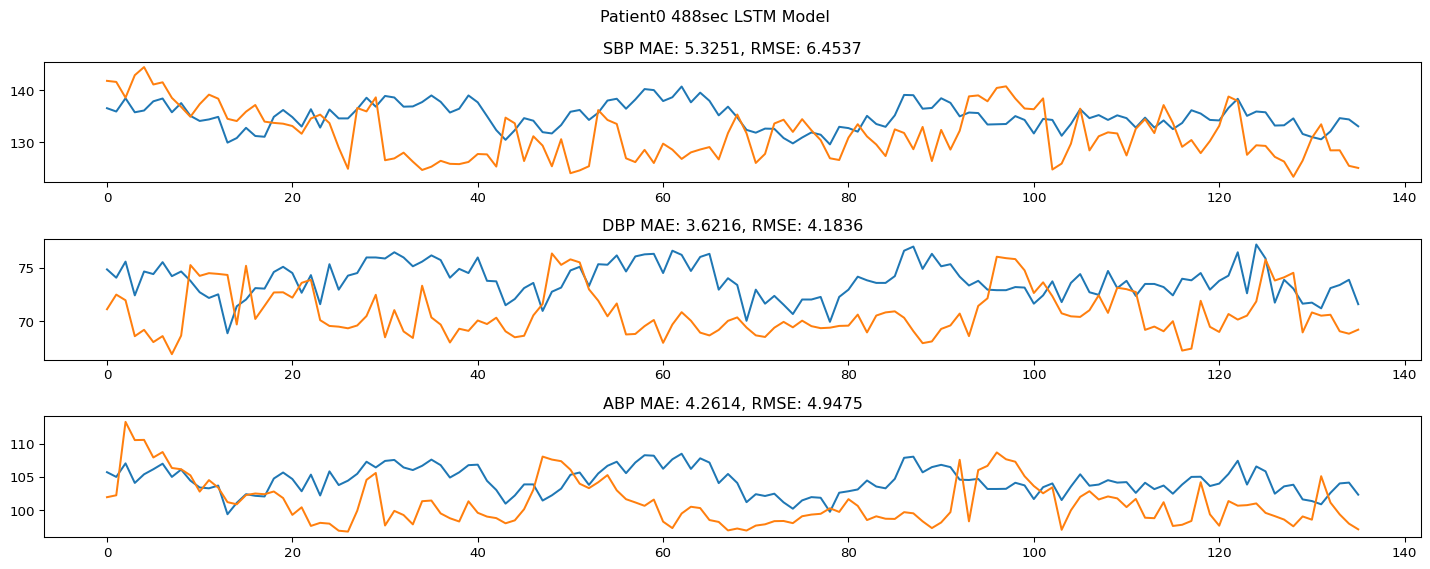

In [95]:
import numpy as np
#import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import joblib
from tensorflow.keras import backend as K
def custom_loss(y_true, y_pred):
    bp_true = y_true * (max(pt_ori['BP'])-min(pt_ori['BP'])) + min(pt_ori['BP'])
    bp_pred = y_pred * (max(pt_ori['BP'])-min(pt_ori['BP'])) + min(pt_ori['BP'])
    mae = K.mean(K.abs(bp_true - bp_pred))
    return mae

def lstm_model():
    model = keras.Sequential([
        layers.LSTM(200, return_sequences=True, input_shape=(time_step, features_reshape.shape[2])),
        layers.Dropout(0.1),
        layers.LSTM(200, return_sequences=True),
        layers.Dropout(0.05),
        layers.LSTM(200, return_sequences=True),
        #layers.Dropout(0.05),
        layers.LSTM(100, return_sequences=True),
        #layers.Dropout(0.05),
        layers.LSTM(100, return_sequences=True),
        #layers.Dropout(0.01),
        layers.LSTM(50),
        layers.Dense(1)
    ])
    return model

def estimate_bp(df=all_features_bps):
    features_bps = df
    features = np.array(features_bps.iloc[:, :-3])
    bps = np.array(features_bps.iloc[:, -3:])

    time_step = 10
    features_reshape = np.zeros(((features.shape[0] - time_step + 1), time_step, features.shape[1]))
    for i in range(len(features_reshape)):
        features_reshape[i] = features[i : (time_step + i)]
    bps_reshape = bps[time_step - 1: ]
    
    train_proportion=0.8
    X_train = features_reshape[ : int((len(features_reshape) * train_proportion))]
    print(f'X_train: {X_train.shape}')
    #print(X_train)
    X_test = features_reshape[int((len(features_reshape) * train_proportion)) : ]
    print(f'X_test: {X_test.shape}')
    #print(X_test)

    '''
    Y_train = bps_reshape[ : int((len(bps_reshape) * train_proportion))]
    print(f'Y_train: {Y_train.shape}')
    #print(Y_train)
    Y_test = bps_reshape[int((len(bps_reshape) * train_proportion)) : ]
    print(f'Y_test: {Y_test.shape}')
    #print(Y_test)

    model = lstm_model()
    model.compile(optimizer='adam', loss=custom_loss)
    model.fit(X_train, Y_train, epochs=100, batch_size=16)
    #joblib.dump(model, 'lstm_model.pkl')
    #loaded_model = joblib.load('model_filename.pkl')
    model.summary()
    Y_prediction = model.predict(X_test)
    print(Y_prediction.shape)

    BP_test = Y_test
    BP_pred = Y_prediction
    '''

    
    BP_test = np.zeros(((len(bps_reshape) - int(len(bps_reshape)*train_proportion)), 3))
    print(f"BP_test: {BP_test.shape}")
    BP_pred = np.zeros(((len(bps_reshape) - int(len(bps_reshape)*train_proportion)), 3))
    print(f'BP_pred: {BP_pred.shape}')

    patient = 0
    #n_seconds_to_load = 100 # seconds
    n_seconds_to_load = int(data["p"][0,patient].shape[1] / fs)
    signal_length = int(n_seconds_to_load * fs)
    #print(signal_length)
    patient_data = data['p'][0,patient][:,:signal_length]
    print(f'Patient {patient} length: {data["p"][0,patient].shape[1]}, time: {n_seconds_to_load}')
    ## 3. Choose signals of this patient
    pt_ori = {'PPG': patient_data[0], 'BP': patient_data[1], 'ECG': patient_data[2]}

    for bp in range(3):
        bp_reshape = bps_reshape[: , bp]
        Y_train = bp_reshape[ : int((len(bps_reshape) * train_proportion))]
        print(f'Y_train: {Y_train.shape}')
        #print(Y_train)
        Y_test = bp_reshape[int((len(bps_reshape) * train_proportion)) : ]
        print(f'Y_test: {Y_test.shape}')
        #print(Y_test)

        model = lstm_model()
        model.compile(optimizer='adam', loss=custom_loss)
        model.fit(X_train, Y_train, epochs=200, batch_size=16)
        #joblib.dump(model, 'lstm_model.pkl')
        #loaded_model = joblib.load('model_filename.pkl')
        model.summary()
        Y_prediction = model.predict(X_test)
        Y_prediction = Y_prediction.flatten()
        print(Y_prediction.shape)

        BP_test[ : , bp] = (Y_test * (max(pt_ori['BP'])-min(pt_ori['BP']))) + min(pt_ori['BP'])
        BP_pred[ : , bp] = (Y_prediction * (max(pt_ori['BP'])-min(pt_ori['BP']))) + min(pt_ori['BP'])
    
    ## BPs results
    results = {}
    results['BP'] = ['SBP', 'DBP', 'ABP']
    results['MAE'] = ["{:.4f}".format(np.mean(np.abs(BP_pred[: , i] - BP_test[: , i]))) for i in range(3)]
    results['RMSE'] = ["{:.4f}".format((np.sqrt(sum((BP_pred[: , i] - BP_test[: , i]) ** 2) / len(BP_test[: , 0])))) for i in range(3)]

    ## Compare BPs 
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 6), dpi=96)
    for i in range(3):
        axs[i].plot(BP_test[: , i])
        axs[i].plot(BP_pred[: , i])
        axs[i].set_title(f'{results["BP"][i]} MAE: {results["MAE"][i]}, RMSE: {results["RMSE"][i]}')

    fig.suptitle(f'Patient{patient} {n_seconds_to_load}sec LSTM Model')
    plt.tight_layout()
    plt.savefig(f'Patient{patient}_{n_seconds_to_load}Sec_LSTM.png', format='png')
    plt.show()
    return 

estimate_bp(all_features_bps)